In [3]:
from google.colab import drive
import pandas as pd
import pickle

drive.mount('/content/drive')


file_path_ori = '/content/drive/My Drive/GDG_ML_WING_DATASET/preprocesss_dataset.csv'
# file_path_top = '/content/drive/My Drive/GDSC_DATASET/topline_result.dat'
# file_path_base = '/content/drive/My Drive/GDSC_DATASET/baseline_result.dat'
TOP_info = 0
base_info = 0
try:
    with open(file_path_ori, 'r') as f:
        DATA = pd.read_csv(file_path_ori)
    # with open(file_path_top, 'rb') as f:
    #     TOP_info = pickle.load(f)
    # with open(file_path_base, 'rb') as f:
    #     base_info = pickle.load(f)
except FileNotFoundError:
    print("File NOT FOUND. Check the path and filename.")

Mounted at /content/drive


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [5]:
# X = your preprocessed feature matrix
# y = your target labels

# Define features (X) and target (y)
X = DATA.drop('role', axis=1)  # Features are all columns except 'role'
y = DATA['role']  # Target variable is 'role'

In [6]:
# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include='object').columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['committype', 'fileextensions', 'timeofcommit', 'commitmessage',
       'clean_commit'],
      dtype='object')


In [7]:
# Handle categorical features (e.g., one-hot encoding for 'committype')
if 'committype' in non_numeric_cols:
  X = pd.get_dummies(X, columns=['committype'], drop_first=True)
  # non_numeric_cols = non_numeric_cols.drop('committype') # Remove 'committype' from the list
# Re-identify non-numeric columns after one-hot encoding
non_numeric_cols = X.select_dtypes(include='object').columns
print("Non-numeric columns after one-hot encoding:", non_numeric_cols)

Non-numeric columns after one-hot encoding: Index(['fileextensions', 'timeofcommit', 'commitmessage', 'clean_commit'], dtype='object')


In [8]:
# Drop remaining non-numeric columns
X = X.drop(columns=non_numeric_cols)

In [9]:
# Step 1: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Step 2: Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Euclidean distance


In [11]:
# Step 3: Train model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [12]:
# Step 4: Predictions
y_pred = knn.predict(X_test)

In [13]:
# Step 5: Evaluation
print("✅ KNN Model Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ KNN Model Results
Accuracy: 0.4866666666666667

Classification Report:
               precision    recall  f1-score   support

     backend       0.43      0.65      0.52        97
    frontend       0.39      0.35      0.37        89
   fullstack       0.70      0.40      0.51        52
          qa       0.70      0.50      0.58        62

    accuracy                           0.49       300
   macro avg       0.56      0.48      0.50       300
weighted avg       0.52      0.49      0.49       300


Confusion Matrix:
 [[63 26  7  1]
 [44 31  2 12]
 [27  4 21  0]
 [12 19  0 31]]


In [14]:
from sklearn.metrics import f1_score

y_pred = knn.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print("Macro F1:", macro_f1)

Macro F1: 0.49562080154313504


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

     backend      0.432     0.649     0.519        97
    frontend      0.388     0.348     0.367        89
   fullstack      0.700     0.404     0.512        52
          qa      0.705     0.500     0.585        62

    accuracy                          0.487       300
   macro avg      0.556     0.475     0.496       300
weighted avg      0.521     0.487     0.486       300



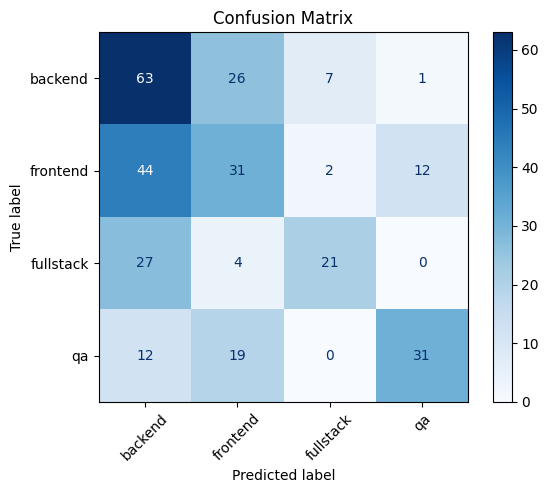

In [17]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Plotting calibration for class: backend


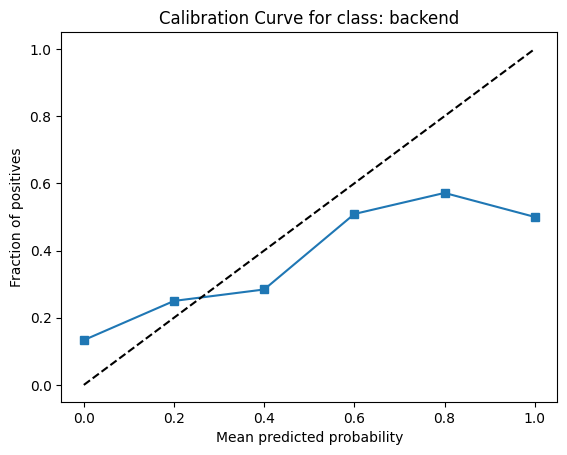

In [19]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Note: calibration_curve is primarily for binary classification.
# For multi-class, you might need to adapt or use other techniques.

# Use knn instead of log_reg
# The .predict_proba gives probabilities for each class.
# You would typically analyze calibration for each class separately in multi-class.
# For demonstration, let's plot for one class (e.g., the first class in knn.classes_)
class_index_to_plot = 0 # You can change this to the index of the class you want to analyze

if len(knn.classes_) == 2:
    # Binary case: directly use predict_proba for the positive class
    prob_pos = knn.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Calibration Curve")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.show()
else:
    # Multi-class case: plot calibration for a specific class
    print(f"Plotting calibration for class: {knn.classes_[class_index_to_plot]}")
    # Create a binary target for the selected class
    y_test_binary = (y_test == knn.classes_[class_index_to_plot])
    prob_pos = knn.predict_proba(X_test)[:, class_index_to_plot]

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_binary, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"Calibration Curve for class: {knn.classes_[class_index_to_plot]}")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.show()

In [21]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

results_list = []

# Create a temporary DataFrame for the test set that includes 'committype' and true/predicted labels
# We need the original 'committype' from the DATA DataFrame for the test set
test_data_with_committype = DATA.loc[X_test.index, ['committype']].copy()
test_data_with_committype['y_true'] = y_test
test_data_with_committype['y_pred'] = y_pred


for ct in test_data_with_committype["committype"].unique():
    subset = test_data_with_committype[test_data_with_committype["committype"] == ct]
    y_true_subset = subset["y_true"]
    y_pred_subset = subset["y_pred"]

    # Get unique labels in the subset to use for metrics calculation
    # Ensure all possible labels from y_test are considered even if they are not in the subset
    subset_labels = sorted(y_test.unique())

    # Calculate metrics for the subset
    # Use zero_division=0 to handle cases where a class has no predicted instances in the subset
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_subset, y_pred_subset, labels=subset_labels, average=None, zero_division=0
    )

    # Store results
    for i, label in enumerate(subset_labels):
        results_list.append({
            "Commit Type": ct,
            "Role": label,
            "Precision": precision[i],
            "Recall": recall[i],
            "F1-Score": f1[i],
            "Support": support[i]
        })

# Create a DataFrame from the results
metrics_df = pd.DataFrame(results_list)

# Display the DataFrame
display(metrics_df)

,Commit Type,Role,Precision,Recall,F1-Score,Support
0,test,backend,0.000000,0.000000,0.000000,0
1,test,frontend,0.000000,0.000000,0.000000,0
2,test,fullstack,0.000000,0.000000,0.000000,2
3,test,qa,1.000000,0.553191,0.712329,47
4,feature,backend,0.493151,0.692308,0.576000,52
5,feature,frontend,0.600000,0.344262,0.437500,61
6,feature,fullstack,0.700000,0.411765,0.518519,17
7,feature,qa,0.000000,0.000000,0.000000,0
8,bugfix,backend,0.456522,0.617647,0.525000,34
9,bugfix,frontend,0.058824,0.125000,0.080000,8


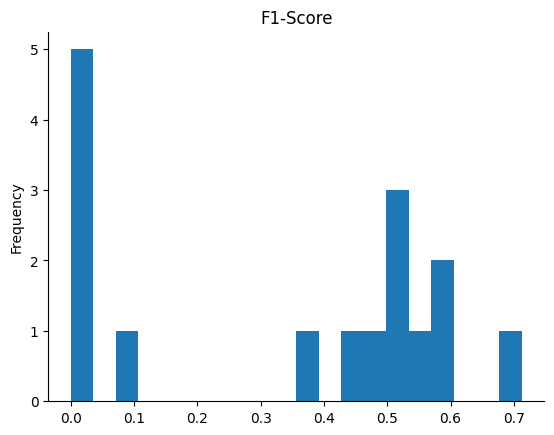

In [23]:
# Plot of f1 score
from matplotlib import pyplot as plt
metrics_df['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [22]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=metrics_df)

https://docs.google.com/spreadsheets/d/1NtxGLy0PEpCwjkCNmqNXO4Gs9j-87clVHDG45gUkjls/edit#gid=0
